# Tutorial: Data-Driven Proposals with PyTorch

This tutorial is a short extension to [Data-Driven Proposals in Gen](../Data-Driven%20Proposals%20in%20Gen.jl), 
which shows how to use PyTorch for easier specification of the proposal.

For this tutorial, you'll need to ensure that you have PyCall installed, and pointing to a Python that has Torch installed.

In [1]:
using Gen, GenPyTorch, PyCall

We recreate the relevant parts of the model from the Data-Driven Proposals in Gen tutorial:

In [2]:
include("../../inverse-planning/geometric_primitives.jl");
include("../../inverse-planning/scene.jl");
include("../../inverse-planning/viz.jl")
include("../../inverse-planning/planning.jl");

scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(rrt_iters=600, rrt_dt=0.05,
                               refine_iters=3500, refine_std=1.);

@gen function agent_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

PyCall allows us to import Python libraries directly into our Julia code:

In [3]:
torch = pyimport("torch")
nn = torch.nn
F = nn.functional

PyObject <module 'torch.nn.functional' from '/Users/alexlew/gen-quickstart/tutorials/pytorch/venv/lib/python3.9/site-packages/torch/nn/functional.py'>

It also provides the `@pydef` macro, which we can use to define Python classes using Julia code.
In PyTorch, new neural network architectures are defined as subclasses
of the `nn.Module` class. We create our own neural network class here, 
called `NeuralProposal`. 

Every module needs to define two methods: `__init__` and `forward`.

In `__init__`, we create any layers we will use later. The expression 
`nn.Linear(input_dim, output_dim)` creates a fully-connected layer mapping
a given number of input dimensions to a given number of output dimensions.
Here, we construct three such layers: `fc1` maps our four inputs to 50 hidden
units, `fc2` transforms the 50 hidden units, and `fc3` maps the 50 hidden
units to 5 output neurons, which will later be normalized into the 5
bin probabilities for `dest_x` or `dest_y`. (PyTorch also comes with helpers
for constructing more complex layers, including convolutional layers and RNN
cells, but we do not cover that here.)

The `forward` function actually implements the neural network's computation,
making use of any layers created in `__init__`. Here, we use `ReLU` activation
functions, instead of the `tanh`-based activation used in the previous section.

In [34]:
@pydef mutable struct NeuralProposal <: nn.Module
    function __init__(self, num_in)
        # Note the use of pybuiltin(:super): built in Python functions
        # like `super` or `str` or `slice` are all accessed using
        # `pybuiltin`.
        pybuiltin(:super)(NeuralProposal, self).__init__()
        self.fc1 = nn.Linear(num_in, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 5)
    end

    function forward(self, x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    end
end

PyObject <class 'NeuralProposal'>

Once we've defined a `nn.Module`, we can create a generative function out of it
using the `TorchGenerativeFunction` constructor. The first argument is an
instantiated Torch model, in our case, `NeuralProposal(4)`. Here, `4` is the
value we are passing into `NeuralProposal`'s `__init__` method, which expects
us to provide `num_in`, the number of input units. The second argument to
`TorchGenerativeFunction` is a list of `TorchArg` objects, describing the 
arguments to the `forward` function. We have only one argument, `x`, so we pass
in a list of one element. A `TorchArg` object specifies the argument's `dtype` 
(`torch.float` in this case, for 32-bit floating-point numbers), and a Boolean
for whether gradients should flow through this argument (almost always `true`, unless
the argument is some discrete value, e.g., a Boolean flag). Finally, we pass in
the number of output tensors to expect from calling `forward` -- in this case, just one.

In [35]:
x_nn = TorchGenerativeFunction(NeuralProposal(4), [TorchArg(true, torch.float)], 1);

`x_nn` can now be called on inputs:

In [36]:
x_nn([0.0, 0.0, 0.0, 0.0])

5-element Vector{Float64}:
 -0.07767701894044876
  0.006771232932806015
 -0.06922771036624908
 -0.11070195585489273
  0.028574829921126366

To turn these into bin probabilities, we'll use `softmax`:

In [37]:
softmax(logits) = exp.(logits .- logsumexp(logits))

softmax(x_nn([0.0, 0.0, 0.0, 0.0]))

5-element Vector{Float64}:
 0.19319124522982853
 0.21021458830983716
 0.19483049317822299
 0.18691531798546976
 0.2148483552966415

Our proposal in this section will actually use _two_ neural networks: after 
generating a `dest_x` using the probabilities from `x_nn`, it will generate
a `dest_y` from a second network, `y_nn`. But `y_nn` will take an additional
argument: the sampled `dest_x` value. This way, in theory, the `y` neural network
can propose different `dest_y` values depending on the sampled `x`.

To this end, we create a `y_nn` that accepts 5 inputs, rather than 4. Note that
every time we call `NeuralProposal(...)`, it is calling `__init__` to generate a
fresh set of layers and their parameters; so the parameters are not shared between
`x_nn` and `y_nn`.

In [38]:
y_nn = TorchGenerativeFunction(NeuralProposal(5), [TorchArg(true, torch.float)], 1);

We are now ready to write our custom proposal, which calls each neural 
network to generate probabilities, then samples using `piecewise_uniform`.
Note that because the neural networks are generative functions, we call them
using `~` --- even though they make no random choices. This is important for
Gen's gradient-based optimization features to work properly.

In [49]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5
num_x_bins = 5
num_y_bins = 5;

@gen function custom_dest_proposal_torch(measurements::Vector{Point}, scene::Scene)
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs ~ x_nn([x_first, y_first, x_last, y_last])
    dest_x ~ piecewise_uniform(x_bounds, softmax(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    y_probs ~ y_nn([x_first, y_first, x_last, y_last, dest_x])
    
    dest_y ~ piecewise_uniform(y_bounds, softmax(y_probs))
    
    return nothing
end;

To train the proposal, we construct an update that applies a fixed step size gradient descent move. We indicate that we want the update to apply to all the trainable parameters of `x_nn` and all the trainable parameters of `y_nn`. Note that `custom_dest_proposal_torch` does not have any trainable parameters of its own, unlike `custom_dest_proposal_neural`.

In [50]:
update = Gen.ParamUpdate(Gen.ADAM(0.001, 0.9, 0.999, 1e-8), 
    x_nn => collect(get_params(x_nn)), y_nn => collect(get_params(y_nn)));

And run the training procedure. Here, we've used the more effective ADAM
optimizer, so we can get by with less training. (But more training
may still help, and you may decide to run it for more epochs or larger epochs!
If you have a GPU available, GenPyTorch should automatically use it.)

In [51]:
function data_generator()
    
    # since these names are used in the global scope, explicitly declare it
    # local to avoid overwriting the global variable
    local measurements
    local choices
    
    # obtain an execution of the model where planning succeeded
    done = false
    while !done
        (choices, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
        (planning_failed, maybe_path) = retval       
        done = !planning_failed
    end

    # construct arguments to the proposal function being trained
    measurements = [Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    # construct constraints for the proposal function being trained
    constraints = Gen.choicemap()
    constraints[:dest_x] = choices[:dest_x]
    constraints[:dest_y] = choices[:dest_y]
    
    return (inputs, constraints)
end;

In [52]:
Gen.train!(custom_dest_proposal_torch, data_generator, update,
    num_epoch=10, epoch_size=100, num_minibatch=100, minibatch_size=100,
    evaluation_size=10, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 100 minibatches of size 100...
epoch 1: evaluating on 10 examples...
epoch 1: est. objective value: 0.30674785750200567
epoch 2: generating 100 training examples...
epoch 2: training using 100 minibatches of size 100...
epoch 2: evaluating on 10 examples...
epoch 2: est. objective value: 0.057911306335681687
epoch 3: generating 100 training examples...
epoch 3: training using 100 minibatches of size 100...
epoch 3: evaluating on 10 examples...
epoch 3: est. objective value: 1.195958290383073
epoch 4: generating 100 training examples...
epoch 4: training using 100 minibatches of size 100...
epoch 4: evaluating on 10 examples...
epoch 4: est. objective value: 0.36682692005589856
epoch 5: generating 100 training examples...
epoch 5: training using 100 minibatches of size 100...
epoch 5: evaluating on 10 examples...
epoch 5: est. objective value: 0.8955448017601333
epoch 6: generating 100 training examples...
epoch 6: tra

We can visualize the proposal and see that although it's not perfect, it correctly
focuses on the upper left regions of the scene. 

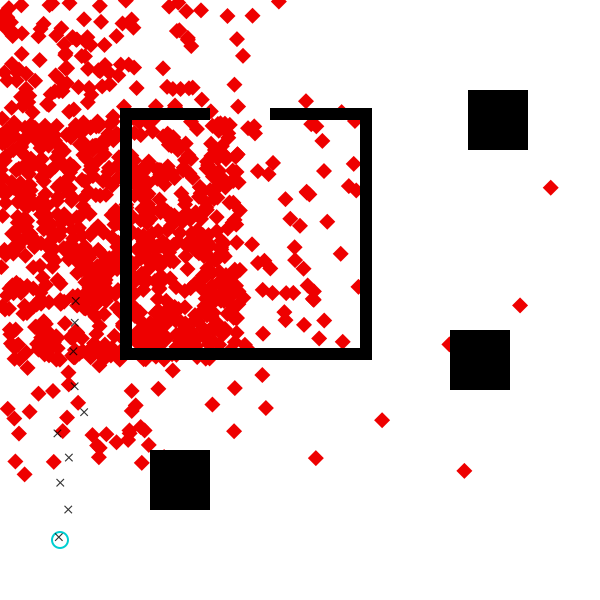

In [55]:
function visualize_custom_destination_proposal(measurements, start, dest_proposal; num_samples=100)
    visualize() do 
        for i=1:num_samples
            (proposed_choices, _) = Gen.propose(dest_proposal, (measurements, scene))
            constraints = choicemap(proposed_choices)
            constraints[:start_x] = start.x
            constraints[:start_y] = start.y
            (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
            draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
        end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_torch, num_samples=1000)

### Exercise

Give brief answers for the following questions:

1. Do you expect that the neural proposal trained above would work all right for _observed agent locations_ different from the ones we've been working with in this notebook? Why or why not?
2. Do you expect that the neural proposal trained above would work all right for _scenes_ different from the one we've been working with in this notebook? Why or why not? (For example, would it do well in the `scene_2doors` scene from Problem 2.4? If so, can you imagine other scenes where it would fail?)
3. If you answered "no" to either of the above questions, can you describe (but not implement!) a modification to the neural network architecture, the training procedure, or both that would allow you to answer "yes"?

--------
### Exercise

The training procedure for the neural networks above was not vectorized across training examples. For fast training on a GPU it is important to vectorize the evaluation of gradients across multiple training examples. Write a vectorized version of the `custom_dest_proposal_torch` that takes a scene and a vector of data sets (measurement vectors), and samples a destination point for each of the input data sets. Train it and visualize the proposal distribution, and the results of importance resampling inference that using the proposal for some amount of computation, for our example data set.

Hint:

- Construct a vectorized version of each of the neural networks that operate
  on an extra 'training example' dimension.

- Construct a vectorized version of the proposal. It should accept a vector
  of measurement vectors as one of its arguments. This vectorized propsal
  should make 2N random choices where N is the batch size.

- Construct a vectorized version of the data generator. It should generate
  constraints for all random choices of the vectorized proposal.

- Construct a non-vectorized version of the proposal that invokes the
  vectorized neural networks on a single data set.